# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem statement <br>

The aim of this project is to identify whether offer provided by starbucks is reaching target audience and classify offers are helping to complete the transaction

## Metrics:

The classification model has the accuracy metrics of 97% F1 score

In [1]:
import pandas as pd
import numpy as np
import math
import json
 
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
print(portfolio.columns)
portfolio.head(10)


Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward'], dtype='object')


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


## Data Cleaning

**Clean Portfolio**

Set proper columns names for Portfolio
One hot encode for Channels and Offertype since they are categorical

In [3]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

portfolio.columns=['Channels','MinAmountRequired','DurationDays','OfferId','OfferType','Reward']
offer_df=pd.get_dummies(portfolio['OfferType'])


ml_binarizerobj = MultiLabelBinarizer()
ml_binarizerobj.fit(portfolio['Channels'])

channels_df =pd.DataFrame(ml_binarizerobj.transform(portfolio['Channels']), columns=ml_binarizerobj.classes_)
                         
portfolio=pd.concat([portfolio,offer_df,channels_df],axis=1)
portfolio.drop(columns=['OfferType', 'Channels'],inplace=True)




In [4]:
portfolio.head()

,MinAmountRequired,DurationDays,OfferId,Reward,bogo,discount,informational,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,0,1


In [5]:

profile.columns=['Age','MemberSince','Gender','PersonId','Income']
profile.head()

,Age,MemberSince,Gender,PersonId,Income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


## Data Exploration

### Number of Unique customers are 17000

In [6]:
print(profile['PersonId'].nunique())

17000


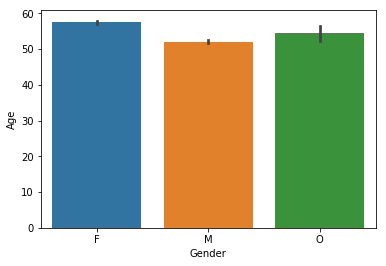

In [7]:
import seaborn as sns
sns.barplot(data=profile,x='Gender',y='Age')




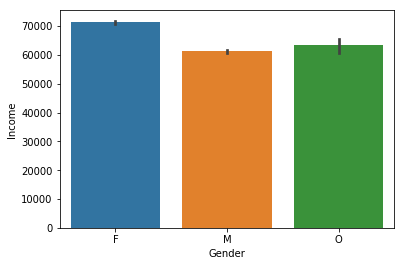

In [8]:
import seaborn as sns
sns.barplot(data=profile,x='Gender',y='Income')

In [9]:
transcript.head()
transcript.columns=['Event', 'PersonId', 'Days', 'Transaction']

In [10]:

transcript_df=transcript.groupby(['Event']).PersonId.count().reset_index()
transcript_df

,Event,PersonId
0,offer completed,33579
1,offer received,76277
2,offer viewed,57725
3,transaction,138953


In [11]:
transaction=(transcript[transcript.Event=='transaction'])
transaction.head(5)

,Event,PersonId,Days,Transaction
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [12]:
transcript[transcript.Event=='offer viewed'].head(5)

,Event,PersonId,Days,Transaction
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [13]:
transcript[transcript.Event=='offer completed'].head(5)

,Event,PersonId,Days,Transaction
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


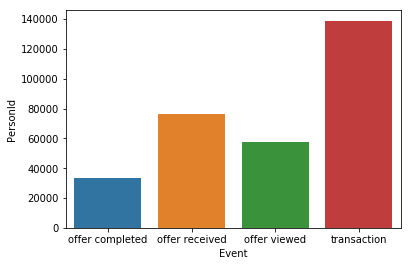

In [14]:
sns.barplot(data=transcript_df,x='Event',y='PersonId')

# plt.show()

In [15]:
transcript[transcript.Event=='offer viewed'].head()

,Event,PersonId,Days,Transaction
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


Offer view,received and completed has offer id in Transaction,so some prepocessing is required


In [16]:
transcript['offerId']=transcript.Transaction.apply(lambda x:x.get(list(x.keys())[0]))


In [17]:
transcript['Amount']=transcript.Transaction.apply(lambda x:x.get("amount"))

In [18]:
transaction_complted=transcript[transcript.Event=='offer completed']
# transaction_complted['offerId']=transcript.Transaction.apply(lambda x:x.get("offer_id"))

In [19]:
transcript[transcript.Event=='offer completed'].head(5)

,Event,PersonId,Days,Transaction,offerId,Amount
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,NaN
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,NaN
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [20]:
transcript.head()

,Event,PersonId,Days,Transaction,offerId,Amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [21]:
transcript['Days']=transcript['Days']/24

In [22]:
merged = pd.merge(transcript , profile ,left_on='PersonId' , right_on='PersonId',how='inner')
# merged.drop(columns=['PersonId'] , inplace=True)
merged.drop(columns=['Transaction'] , inplace=True)

merged.Amount.fillna(0 , inplace=True)

In [23]:
merged.head()

,Event,PersonId,Days,offerId,Amount,Age,MemberSince,Gender,Income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,75,20170509,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,75,20170509,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.50,19.89,19.89,75,20170509,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,75,20170509,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.00,17.78,17.78,75,20170509,F,100000.0


In [24]:
merged_final = pd.merge(merged , portfolio ,left_on='offerId' , right_on='OfferId',how='inner')
# merged_final = pd.merge(merged_final , transaction ,left_on='OfferId' , right_on='OfferId',how='inner')
merged_final.drop(columns=['OfferId'] , inplace=True)

In [25]:
merged_final.head()

,Event,PersonId,Days,offerId,Amount,Age,MemberSince,Gender,Income,MinAmountRequired,DurationDays,Reward,bogo,discount,informational,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,100000.0,5,7,5,1,0,0,1,1,0,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,100000.0,5,7,5,1,0,0,1,1,0,1
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,100000.0,5,7,5,1,0,0,1,1,0,1
3,offer received,e2127556f4f64592b11af22de27a7932,17.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,70000.0,5,7,5,1,0,0,1,1,0,1
4,offer viewed,e2127556f4f64592b11af22de27a7932,17.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,70000.0,5,7,5,1,0,0,1,1,0,1


### Only 44% customers completed offer

In [26]:
mergedGroup= merged_final.groupby(['Event']).PersonId.count()

In [27]:
mergedGroup

Event
offer completed    33579
offer received     76277
offer viewed       57725
Name: PersonId, dtype: int64

In [28]:
# merged2_final=pd.merge(merged_final , transaction_complted ,left_on='offerId' , right_on='offerId',how='right')

In [29]:
mergedGroup= merged_final.groupby(['Event','PersonId']).offerId.count().reset_index()

In [30]:
merged_final[merged_final['Event']=='offer received'].groupby(['offerId']).PersonId.count()

offerId
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
3f207df678b143eea3cee63160fa8bed    7617
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
5a8bc65990b245e5a138643cd4eb9837    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
ae264e3637204a6fb9bb56bc8210ddfd    7658
f19421c1d4aa40978ebb69ca19b0e20d    7571
fafdcd668e3743c1bb461111dcafc2a4    7597
Name: PersonId, dtype: int64

### Offer completed by both Men and Female are almost same

In [31]:
merged_final[merged_final['Event']=='offer completed'].groupby(['Gender']).offerId.count().reset_index()

,Gender,offerId
0,F,15477
1,M,16466
2,O,501


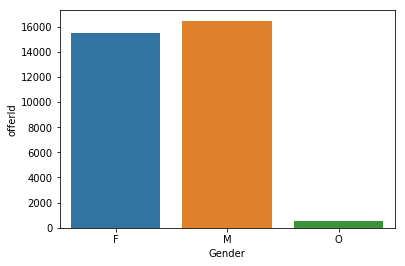

In [32]:
sns.barplot(data=merged_final[merged_final['Event']=='offer completed'].groupby(['Gender']).offerId.count().reset_index(),x='Gender',y='offerId')

### Hot encoding 'Offer completed' to make it as label

In [33]:
event_final=pd.get_dummies(merged_final['Event'])


In [34]:
model_final=pd.concat([merged_final,event_final],axis=1)
model_final.drop(columns=['offer received', 'offer viewed'],inplace=True)

In [35]:
model_final.head()

,Event,PersonId,Days,offerId,Amount,Age,MemberSince,Gender,Income,MinAmountRequired,DurationDays,Reward,bogo,discount,informational,email,mobile,social,web,offer completed
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,100000.0,5,7,5,1,0,0,1,1,0,1,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,100000.0,5,7,5,1,0,0,1,1,0,1,0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,20170509,F,100000.0,5,7,5,1,0,0,1,1,0,1,1
3,offer received,e2127556f4f64592b11af22de27a7932,17.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,70000.0,5,7,5,1,0,0,1,1,0,1,0
4,offer viewed,e2127556f4f64592b11af22de27a7932,17.50,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,20180426,M,70000.0,5,7,5,1,0,0,1,1,0,1,0


In [36]:
len(model_final[model_final['Event']=='offer received'])

76277

In [37]:
model_final=model_final.drop(model_final[model_final['Event']=='offer viewed'].index)

In [38]:
model_final.groupby('offer completed').PersonId.count().reset_index()

ModelData=model_final.drop(columns=['offer completed','Event','PersonId','offerId','Gender','Income'])


## Data Modeling

In [39]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

X_Data=ModelData
Y_Data=model_final['offer completed']

In [40]:
len(X_Data)

109856

In [41]:
len(Y_Data)

109856

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_Data, Y_Data, random_state=42)

In [43]:

model2 = GaussianNB()

model2.fit(X_train, y_train)

GaussianNB(priors=None)

In [44]:

print('Train F1_score {}'.format( model2.score(X_train,y_train)))
print('Test F1_score {}'.format(model2.score(X_test,y_test)))

Train F1_score 0.6283619768909603
Test F1_score 0.6267841538013399


In [45]:
model1 = KNeighborsClassifier()
model1.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [46]:

print('Train F1_score {}'.format( model1.score(X_train,y_train)))
print('Test F1_score {}'.format(model1.score(X_test,y_test)))

Train F1_score 0.7512986697737645
Test F1_score 0.6136760850568016


In [47]:
model4 = AdaBoostClassifier()
model4.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [48]:

print('Train F1_score {}'.format( model4.score(X_train,y_train)))
print('Test F1_score {}'.format(model4.score(X_test,y_test)))

Train F1_score 0.9721696281192349
Test F1_score 0.971453539178561


## Final Conclusion

Offer completed by both Male and Female are almost same.<br>
Only 44% customers completed offer.<br>
Created model to predict the offer received by customer will complete it or not.<br>
This is a clasification model.<br>
The classification model shows the offer like Bogo and discount help customer to respond to the offer.<br>
The metrics shows AdaBoostClassiifier performed well with 97% accuracy,but it may be overfitted.<br>
Starbucks need to increase offers for more customer response.<br>